In [239]:
import pandas as pd
import numpy as np
import string
import re
import nltk
import pickle
import seaborn as sb
import matplotlib.pyplot as plt

In [240]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

# Data Management

In [241]:
df = pd.read_csv('sentiment_140.csv', sep=',', encoding='latin-1', names=["target","ids","date","user","text"])

In [242]:
df.head(3)

,target,ids,date,user,text
0,0,1467810369,Apr 06 22:19:45,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Apr 06 22:19:49,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Apr 06 22:19:53,mattycus,@Kenichan I dived many times for the ball. Man...


In [243]:
df.shape

(1600000, 5)

In [244]:
df.dtypes

target     int64
ids        int64
date      object
user      object
text      object
dtype: object

In [245]:
df.describe(exclude="int")

,date,user,text
count,1600000,1600000,1600000
unique,774363,659775,1581463
top,Jun 15 12:53:14,lost_dog,isPlayer Has Died! Sorry
freq,20,549,210


In [246]:
df.groupby('target').describe(exclude=["int"])

date                                  user                       \
         count  unique              top freq   count  unique          top   
target                                                                      
0       800000  593879  Jun 22 12:22:23    9  800000  415671     lost_dog   
4       800000  286578  May 22 05:10:17   17  800000  376569  what_bugs_u   

               text                                          
       freq   count  unique                        top freq  
target                                                       
0       549  800000  790184  isPlayer Has Died! Sorry   210  
4       246  800000  793504              good morning   118

In [247]:
df['length'] = df['text'].apply(len)
df.head(3)

,target,ids,date,user,text,length
0,0,1467810369,Apr 06 22:19:45,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115
1,0,1467810672,Apr 06 22:19:49,scotthamilton,is upset that he can't update his Facebook by ...,111
2,0,1467810917,Apr 06 22:19:53,mattycus,@Kenichan I dived many times for the ball. Man...,89


In [248]:
df[df['target'] == 4].head(3)

,target,ids,date,user,text,length
800000,4,1467822272,Apr 06 22:22:45,ersle,I LOVE @Health4UandPets u guys r the best!!,44
800001,4,1467822273,Apr 06 22:22:45,becca210,im meeting up with one of my besties tonight! ...,72
800002,4,1467822283,Apr 06 22:22:46,Wingman29,"@DaRealSunisaKim Thanks for the Twitter add, S...",137


# Statistics

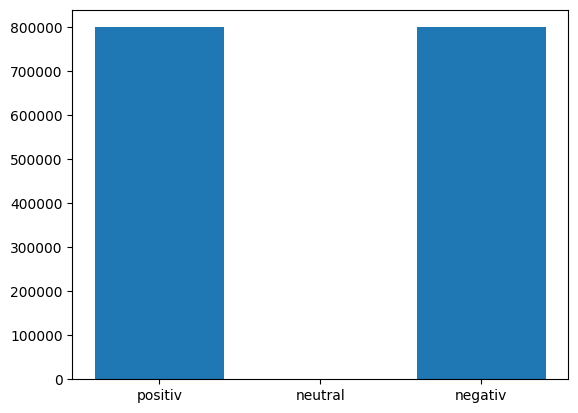

In [249]:
counts = np.array([df[df['target'] == 4].shape[0],df[df['target'] == 2].shape[0], df[df['target'] == 0].shape[0]])
bar_labels = np.array(['positiv', 'neutral', 'negativ'])

plt.bar(bar_labels, counts)

plt.show()

<Figure size 1200x500 with 0 Axes>

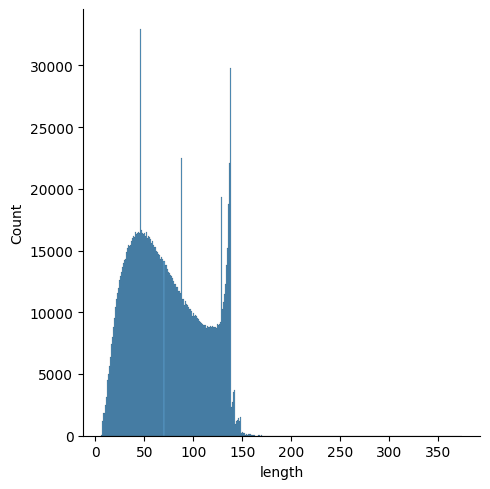

In [250]:
plt.figure(figsize=(12,5))
sb.displot(df[('length')])


# Data CleanUp

### Lowercase

In [251]:
df.text=df.text.str.lower()
df.iloc[1,4]

"is upset that he can't update his facebook by texting it... and might cry as a result  school today also. blah!"

### Punctuation

In [252]:
def remove_punctuation(text):
    result="".join([c for c in text if c not in string.punctuation])
    return result

In [253]:
df['text']=df['text'].apply(lambda x : remove_punctuation(x))

In [254]:
df.iloc[1,4]

'is upset that he cant update his facebook by texting it and might cry as a result  school today also blah'

### URL

In [255]:
df['text']=df['text'].str.replace(r'http\S+|www.\S+','',case=False)

C:\Users\Atlas\AppData\Local\Temp\ipykernel_20756\1494100137.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text']=df['text'].str.replace(r'http\S+|www.\S+','',case=False)


### Number 

In [256]:
df['text']=df['text'].str.replace('\d+', '')
df.iloc[1,4]

C:\Users\Atlas\AppData\Local\Temp\ipykernel_20756\1430431771.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text']=df['text'].str.replace('\d+', '')


'is upset that he cant update his facebook by texting it and might cry as a result  school today also blah'

### Stop words

In [257]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Atlas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [258]:
stop_words = stopwords.words('english')

In [259]:
df['text']=df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df.iloc[1,4]

'upset cant update facebook texting might cry result school today also blah'

### Replace words

In [260]:
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Atlas\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [261]:
words = set(nltk.corpus.words.words())

### Tokenization

In [262]:
df['text'] = (df['text'].astype("str").str.rstrip())
df.iloc[1,4]

'upset cant update facebook texting might cry result school today also blah'

In [263]:
tokenizer=nltk.tokenize.WhitespaceTokenizer()

### Stemming

In [264]:
stemmer = SnowballStemmer("english")

In [265]:
def apply_snowball_stemmer(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text)]

In [266]:
df['text'] = df.text.apply(lambda x :' '.join(apply_snowball_stemmer(x)))
df.iloc[1,4]

'upset cant updat facebook text might cri result school today also blah'

In [267]:
df["text"].head(1)

0    switchfoot bummer shoulda got david carr third...
Name: text, dtype: object

### Lemmatization

In [268]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Atlas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [269]:
lemmatizer=WordNetLemmatizer()

In [270]:
def apply_lemmatizer(text):
    return [lemmatizer.lemmatize(word,"v") for word in tokenizer.tokenize(text)]

In [271]:
df['text']=df.text.apply(lambda x :' '.join(apply_lemmatizer(x)))
df.iloc[1,4]

'upset cant updat facebook text might cri result school today also blah'

In [272]:
corpus = []

for i in range(0, len(df)):
    review = re.sub('[^a-zA-Z0-9]', ' ', df['text'][i])
    review = review.split()
    review = ' '.join(review)
    corpus.append(review)

In [273]:
corpus[1]

'upset cant updat facebook text might cri result school today also blah'

# Model 

In [274]:
#x=df['text']
y=df['target']

In [275]:
x_train, x_test, y_train, y_test = train_test_split(corpus, y, test_size=0.33, random_state=42)

In [276]:
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(analyzer=apply_cleanup)),
    ('transformer', TfidfTransformer()),
    ('model',MultinomialNB())
])

In [277]:
pipeline.fit(x_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer=<function apply_cleanup at 0x000001E880C4F380>)),
                ('transformer', TfidfTransformer()),
                ('model', MultinomialNB())])

# Evaluation 

In [278]:
y_predicted = pipeline.predict(x_test)

In [279]:
print(confusion_matrix(y_test, y_predicted))

[[204077  59244]
 [ 82679 182000]]


In [280]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.71      0.78      0.74    263321
           4       0.75      0.69      0.72    264679

    accuracy                           0.73    528000
   macro avg       0.73      0.73      0.73    528000
weighted avg       0.73      0.73      0.73    528000



In [281]:
print("accuracy | " + str(accuracy_score(y_test, y_predicted)))

accuracy | 0.7312064393939394


# Pickle

In [282]:
pickle.dump(vectorizer, open('vectorizer_tf_idf.pkl', 'wb'))
pickle.dump(model, open('model_random_forest.pkl', 'wb'))

NameError: name 'vectorizer' is not defined